In [264]:
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout, Dense
from keras.models import Sequential 
from keras.optimizers import Adam 
import matplotlib.pyplot as plt 
import seaborn as sns 
from nltk.corpus import stopwords
from nltk.corpus import wordnet 
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import string
import random
from bs4 import BeautifulSoup
import requests
import keras 
import nltk 
import re 
import os 
sns.set_style('darkgrid')

In [265]:
def reproduce():
    os.environ['PYTHONHASHSEED'] = str(42)
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

In [ ]:
# scraping 'steve job by walter issacson' book reviews
session = requests.Session()
order = 'NEGATIVE_FIRST'
# must be > 1
numOfPages = 81

userReview = []

# iterate over each page 
for page in range(1,numOfPages+1):
    url = f'https://www.flipkart.com/steve-jobs/product-reviews/itmfc3dyprnf6ytz?pid=9780349140438&lid=LSTBOK9780349140438TZCNOW&aid=overall&certifiedBuyer=false&sortOrder={order}&page={page}'
    data = session.get(url).text
    soup = BeautifulSoup(data,'lxml')
    reviews = soup.find_all('div',{'class':'_1AtVbE col-12-12'})
    if reviews:
        for review in reviews[4:-1]:
            gr = review.find('div',{'class':''})
            if gr:
                if gr.span:
                    if gr.span.attrs:
                        if gr.div:
                            rev = nltk.sent_tokenize(gr.div.text)
                            full = '_1H-bmy' in gr.span.attrs['class']
                            half = '_1BWGvX' in gr.span.attrs['class']
                            # it True -> remove last sentence of review
                            # bocoz of 'READ MORE'
                            log = half and (half or full)
                            # get rating
                            rate = review.findChildren('div')[4].text
                            if rev:
                                if rate:
                                    if log:
                                        if len(rev) > 1:
                                            userReview.append([' '.join(rev[:-1]).strip(),
                                                               float(rate)])
                                        else:
                                            pass
                                    else:
                                        userReview.append([' '.join(rev).strip(),
                                                           float(rate)])       
    else:
        print('No Reviews')
session.close()

df = pd.DataFrame(userReview,columns=['review','rating'])

try:
    pd.DataFrame(userReview,columns=['review','rating']).to_csv('stevejobs.csv',
                                                                index=False)
    print('Data Succesfully Saved !')
    print('In "stevejobs.csv" file ')
except Exception as error:
    print(error)

In [266]:
# load stopwords
stop_words = set(stopwords.words('english'))

In [267]:
# load dataset 
data = pd.read_csv('stevejobs.csv')
data.head(10)

,review,rating
0,Seems to be a first copy . Cause it's cover pa...,1
1,I want to bring buyers attention that Flipkart...,1
2,The book wasn't has expected. It was like worn...,1
3,Ordered steve jobs writer is issac walter and ...,1
4,I know Price low but book quility is also Low,1
5,Please don't buy this book this is very cheap ...,1
6,This book is not the original version. The con...,1
7,Quality of paper is poor,1
8,Pages come out like hell,1
9,Paper quality is very low 😭😭,1


In [268]:
# check for duplicate rows 
if data.duplicated().sum():
    print(f'No. of duplicated rows : {data.duplicated().sum()}')
    print(data[data.duplicated()])
else:
    print('duplicates already dropped')

No. of duplicated rows : 24
           review  rating
26    Bad quality       1
75    Bad quality       1
159          Good       3
281          Good       4
285          nice       4
301     Nice book       4
313          Good       4
317          Good       4
565     Very nice       5
582          Nice       5
644  Awesome book       5
648     Very nice       5
661    Great book       5
662     Good book       5
668     Good book       5
704          nice       5
714    Great book       5
729     nice book       5
731     Nice book       5
735          nice       5
737          nice       5
747          good       5
763       Awesome       5
776       awesome       5


In [269]:
# drop duplicated rows 
data.drop_duplicates(inplace=True)
print(f'No. of duplicate rows : {data.duplicated().sum()}')

No. of duplicate rows : 0


In [270]:
# text cleaning 
def clean_text(text):
    # remove tags if present
    text = re.sub('@[^\s^:]*','',text)
    # remove links if present 
    text = re.sub('(https|http)://[.\w/]*','',text)
    # remove numbers 
    text = re.sub('[0-9]','',text).strip()
    text = text.lower()
    # removing punctuations 
    text = text.translate(str.maketrans('','',string.punctuation))
    # tokenize text 
    tokens = nltk.word_tokenize(text)
    # removing stopwords 
    text = ' '.join([x.strip() for x in tokens if x not in stop_words])
    # initialize lemmatizer 
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma = []
    for word in nltk.word_tokenize(text):
        pos = nltk.pos_tag([word])[0][-1]
        if pos.startswith('V'):
            lemm_tag = wordnet.VERB
        elif pos.startswith('N'):
            lemm_tag = wordnet.NOUN
        else:
            lemm_tag = wordnet.ADJ
        lemma.append(lemmatizer.lemmatize(word,lemm_tag))
    text = ' '.join(lemma)
    return text.strip()

In [271]:
# adding cleaned review text in 'cleaned_review' column
data['cleaned_review'] = data.review.apply(clean_text)
# reset index
data.reset_index(drop=True,inplace=True)
# add 'label' column
data['label'] = data.rating.apply(lambda x: 'Fantastic' if (x == 5) else 'Very Good' if (x == 4) else 'Not Bad' if (x == 3) else 'Bad' if (x == 2) else 'Terrible')
data.head()

,review,rating,cleaned_review,label
0,Seems to be a first copy . Cause it's cover pa...,1,seem first copy cause cover page roughly finis...,Terrible
1,I want to bring buyers attention that Flipkart...,1,want bring buyer attention flipkart fall low l...,Terrible
2,The book wasn't has expected. It was like worn...,1,book wasnt expect like worn condition,Terrible
3,Ordered steve jobs writer is issac walter and ...,1,order steve job writer issac walter consecutiv...,Terrible
4,I know Price low but book quility is also Low,1,know price low book quility also low,Terrible


In [272]:
print(f'No. of empty rows in column "cleaned_review" : {(data["cleaned_review"] == "").sum()}')

No. of empty rows in column "cleaned_review" : 0


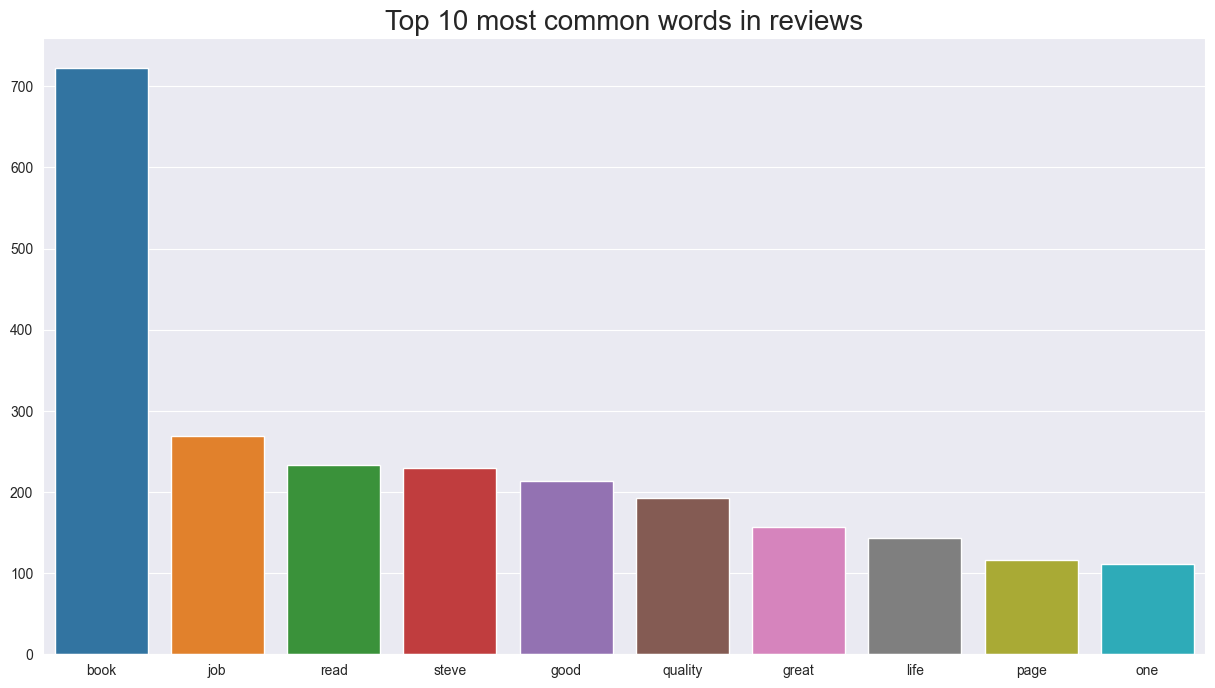

In [273]:
# visualizing word frequency 
freq = nltk.FreqDist(nltk.word_tokenize(' '.join(data.cleaned_review.values)))
plt.figure(figsize=(15,8))
sns.barplot(x=np.array(freq.most_common(10))[:,0],
            y=np.array(freq.most_common(10))[:,1].astype('float'))
plt.title('Top 10 most common words in reviews',
          fontsize=20)
plt.show()

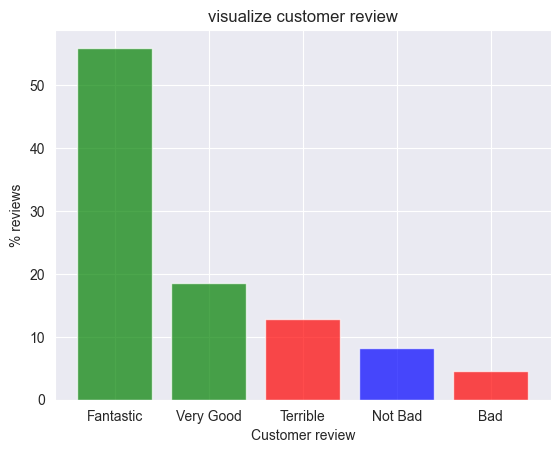

In [274]:
# overall customer review for book 
# 'steve jobs by walter issacson' is fantastic 
# visualizing ratings
color = ['green','green','red','blue','red']
plt.bar(data.label.value_counts().index,
        height=data.label.value_counts().values*100/(data.label.value_counts().values.sum()),
        color=color,alpha=0.7)
plt.ylabel('% reviews')
plt.xlabel('Customer review')
plt.title('visualize customer review')
plt.show()

In [275]:
# features 
features = data[['cleaned_review']]
features.head()

,cleaned_review
0,seem first copy cause cover page roughly finis...
1,want bring buyer attention flipkart fall low l...
2,book wasnt expect like worn condition
3,order steve job writer issac walter consecutiv...
4,know price low book quility also low


In [276]:
# targets 
target = pd.get_dummies(data.label)
target.head()

,Bad,Fantastic,Not Bad,Terrible,Very Good
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [277]:
# word vectorization 
# initializing TfidVectorizer
vec = TfidfVectorizer(min_df=0.0,max_df=1.0,ngram_range=(1,1))
vec.fit(features.cleaned_review.values)
feature_vect = vec.transform(features.cleaned_review.values).toarray()

In [278]:
# set random state
reproduce()
# training Neural Network
model = Sequential()
model.add(Dense(10,input_dim=2437,
                kernel_initializer='uniform',
                activation='relu'))
model.add(Dense(5,kernel_initializer='uniform',
                activation='sigmoid'))
adam = Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy',
              optimizer=adam,metrics=['accuracy'])
model.fit(feature_vect,target.values.astype('float'),
          epochs=10)

Epoch 1/10
24/24 [==============================] - 0s 2ms/step - loss: 0.4436 - accuracy: 0.5482
Epoch 2/10
24/24 [==============================] - 0s 2ms/step - loss: 0.3219 - accuracy: 0.6129
Epoch 3/10
24/24 [==============================] - 0s 2ms/step - loss: 0.2491 - accuracy: 0.7015
Epoch 4/10
24/24 [==============================] - 0s 2ms/step - loss: 0.1844 - accuracy: 0.7952
Epoch 5/10
24/24 [==============================] - 0s 2ms/step - loss: 0.1327 - accuracy: 0.8626
Epoch 6/10
24/24 [==============================] - 0s 2ms/step - loss: 0.1003 - accuracy: 0.8956
Epoch 7/10
24/24 [==============================] - 0s 2ms/step - loss: 0.0837 - accuracy: 0.9089
Epoch 8/10
24/24 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.9353
Epoch 9/10
24/24 [==============================] - 0s 2ms/step - loss: 0.0668 - accuracy: 0.9432
Epoch 10/10
24/24 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9472


In [279]:
# making predictions 
np.set_printoptions(suppress=True)
pred = model.predict(feature_vect)

24/24 [==============================] - 0s 1ms/step


In [280]:
# analysing first 5 reviews
predSamp = pred[5:10].T
data[['review','rating','label']][5:10]

,review,rating,label
5,Please don't buy this book this is very cheap ...,1,Terrible
6,This book is not the original version. The con...,1,Terrible
7,Quality of paper is poor,1,Terrible
8,Pages come out like hell,1,Terrible
9,Paper quality is very low 😭😭,1,Terrible


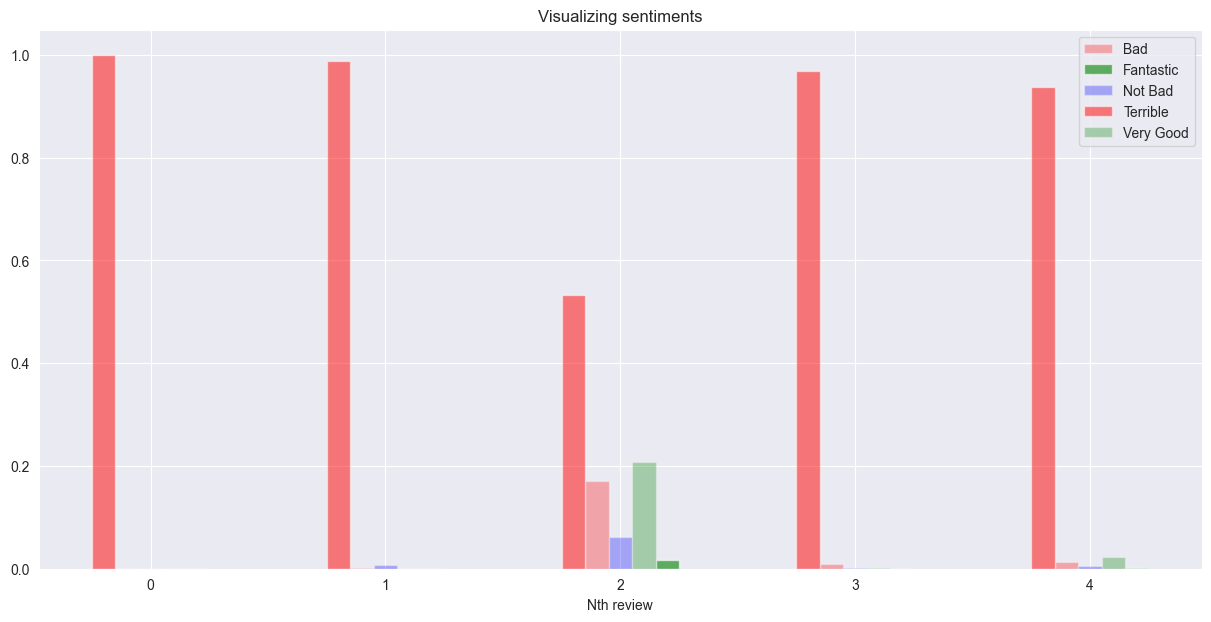

In [281]:
plt.figure(figsize=(15,7))
for i in range(predSamp.shape[-1]):
    color = ['red','green','blue','red','green']
    diff = [-0.1,0.2,0.0,-0.2,0.1]
    alpha = [0.3,0.6,0.3,0.5,0.3]
    w = 0.1
    for j in range(5):
        plt.bar(i+diff[j],predSamp[j][i],width=w,color=color[j],alpha=alpha[j])
plt.legend(target.columns)
plt.title('Visualizing sentiments')
plt.xlabel('Nth review')
plt.show()

## Built NN with 94.72 % accuracy to perform emotion mining on flipkart book reviews